# Dubrow and Divachi 2013
**TODO**: Describe experiment and the implementation of the simulations

**TODO**: Clean up this simluations and re-run simluations for inteligability


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models import SEM, KerasSimpleRNN

np.random.seed(1234)
sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


In [3]:
# N = 30  # 6 events of five objects each
from sklearn.preprocessing import normalize

event_duration = 5
n_events = 5
N = event_duration  * n_events
D = 25

def generate_experiment(seed=None, scaling_factor=1.0):
    if seed:
        np.random.seed(seed)
    
    X = np.random.randn(N, D)

    # embed a similarity structure within the items of each category
    # by adding the same random vector to all of the items within the
    # category
    categ_one = np.random.randn(1, D) * scaling_factor
    categ_two = np.random.randn(1, D) * scaling_factor
    
    for ii in range(n_events):
        if ii % 2 == 0:
            X[ii*event_duration:ii*event_duration +event_duration, :] += categ_one
        else:
            X[ii*event_duration:ii*event_duration +event_duration, :] += categ_two

    return normalize(X)

pre_locs = np.array([ii*event_duration+event_duration for ii in range(n_events-1)])
pst_locs = np.array([ii*event_duration+event_duration-1 for ii in range(n_events-1)])

Set the parameters for the event models

In [4]:
# for our purposes, we need to properly encode the transition function accurately
f_opts=dict( n_epochs=100, optimizer='adam', n_hidden1=D, n_hidden2=D,
    l2_regularization=0.0, dropout=0.00)

In [5]:
X = generate_experiment()

def train_single_event(X):
    event_model = KerasSimpleRNN(D, **f_opts)
    event_model.update_f0(X[0, :])
    for ii in range(1, np.shape(X)[0]):
        event_model.update(X[ii-1, :], X[ii, :])
    return event_model

event_model = train_single_event(X)
print "Event Model Error", np.sum((X - event_model.run_generative(N))**2)

# for comparison, the generative error of an untrained model
null_model = KerasSimpleRNN(D, **f_opts)
print "Null  Model Error", np.sum((X - null_model.run_generative(N))**2)

Event Model Error 1.6047073449436744
Null  Model Error 25.0


In [6]:
# noise parameter
tau = 1.00
X_mem = X + np.random.randn(N, D) * tau

# Reconstruction
Define the two sampling functions used in the reconstruction memory process. One, were all of these scenes are a part of one big event, the other where all are a part of multiple events with unknown type

In [7]:
from tqdm import tnrange

def reconstruction_single_event(X_mem, event_model, tau=1.0, beta=0.01, burn_in=500, 
                                n_samples=500):
    
    #these are shuffeled in order
    trials = range(0, N)
    X_sample = []
    
    # randomly initialize the sampel of X0 from the corruption process
    X0 = np.random.randn(N, D) * tau + X_mem
    
    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)
    lmda = 1.0 / (1./beta + 1./tau)
    
    for ii in tnrange(n_samples + burn_in, leave=False, desc='Gibbs'):
        
        np.random.shuffle(trials) # randomize the order trials are sampled

        for t in trials:
            # pull the transition function
            if t > 1:
                def f(x):
                    return event_model.predict_next_generative(x)
            else:
                def f(x):
                    return event_model.predict_f0()

            # construct the input vector for the model
            X_i = X0[:t, :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
            mu_t = u * f(X_i) + (1 - u) * X_mem[t]

            # generate a sample from the multivariate normal
            X0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))

        if ii >= burn_in:
            X_sample.append(X0.copy())
            
    return np.array(X_sample)

In [8]:
from scipy.stats import multivariate_normal as mvnorm
from scipy.special import logsumexp


def reconstruction_known_boundaries(X_mem, events_dict, event_tokens,
                                    tau=1.0, beta=0.01, burn_in=500, n_samples=500):
    
    #these are shuffeled in order, and we don't want to make a prediction for the last scene
    trials = range(0, N)
    X_sample = []
    
    # randomly initialize the sampel of X0 from the corruption process
    X0 = np.random.randn(N, D) * tau + X_mem
    
    # randomly initialize the identity of the event tokens
    events_keys_function = np.random.permutation(events_dict.keys())
    
    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)
    lmda = 1.0 / (1./beta + 1./tau)
    
    for ii in tnrange(n_samples + burn_in, leave=False, desc='Gibbs'):
        
        np.random.shuffle(trials) # randomize the order trials are sampled

        for t in trials:

            # pull the transition function associated with the current event-token
            token = event_tokens[t]
            token_id = events_keys_function[token]
            if token == event_tokens[t-1]:
                def f(x):
                    return events_dict[token_id].predict_next_generative(x)
            else:
                def f(x):
                    return events_dict[token_id].predict_f0()
                
            # construct the input vector for the model
            X_i = X0[(np.arange(N) < t) & (np.array(event_tokens) == event_tokens[t]), :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
            mu_t = u * f(X_i) + (1 - u) * X_mem[t]

            # generate a sample from the multivariate normal
            X0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))
            
            
        # Here, we sample the events type probability, conditioned on the samples
        
        # we will sample the event models WITHOUT replacement, so keep track 
        # of the available models (this also speeds things up)
        available_models = events_dict.keys()
        
        events_keys_function = np.zeros(len(available_models)) - 1  # reinitialize the key
        
        for token0 in np.random.permutation(list(set(event_tokens))):
            # get the likelihood for each token in the set
            X00 = X0[event_tokens == token0, :]  # pull the relevant scenes
            
            # initialze the scores. This includes models that are not avialble,
            # so they have to be initialized at log p(e) = -infty (or np.log(0))
            scores = np.log(np.zeros(np.max(available_models) + 1))
            
            # loop throught the as yet unassigned models and "score" (log likelihood)
            for token_id0 in available_models:
                # pull the coresponding event model
                e00 = events_dict[token_id0]
                
                # run the model to generate predictions
                X00_hat = np.zeros(np.shape(X00))
                X00_hat[0, :] = e00.predict_f0()
                for jj in range(1, np.shape(X00)[0]):
                    X00_hat[jj, :] = e00.predict_next_generative(X00[:jj, :])
                    
                # evaluate the predictions of the model
                scores[token_id0] = logsumexp(
                    mvnorm.logpdf(X00 - X00_hat, mean=np.zeros(D), cov=np.eye(D) * beta)
                )
            
            # normalize the loglikelihoods and inverse cdf sample
            pmf_e = np.exp(scores - logsumexp(scores))
            cmf_e = np.cumsum(pmf_e)
            e0 =  events_dict.keys()[np.sum(cmf_e < np.random.rand())]
            
            events_keys_function[token0] = e0
            try:
                available_models.remove(e0)        
            except:
                print available_models
                print e0
                print pmf_e
                print scores
                raise(Exception)
                
        if ii >= burn_in:
            X_sample.append(X0.copy())
            
    return np.array(X_sample)

In [9]:
def reconstruction_known_events(X_mem, events_dict, event_tokens,
                                tau=1.0, beta=0.01, burn_in=500, n_samples=500):
    
    #these are shuffeled in order, and we don't want to make a prediction for the last scene
    trials = range(0, N)
    X_sample = []
    
    # randomly initialize the sampel of X0 from the corruption process
    X0 = np.random.randn(N, D) * tau + X_mem
    
    # randomly initialize the identity of the event tokens
    events_keys_function = np.random.permutation(events_dict.keys())
    
    # because the beta and tau are assumed and constant, we can pre-cacluate u 
    # and lambda for the weighted mean of the posterior over x
    u = (1./beta) / (1./beta + 1./tau)
    lmda = 1.0 / (1./beta + 1./tau)
    
    for ii in tnrange(n_samples + burn_in, leave=False, desc='Gibbs'):
        
        np.random.shuffle(trials) # randomize the order trials are sampled

        for t in trials:

            # pull the transition function associated with the current event-token
            token = event_tokens[t]
            if token == event_tokens[t-1]:
                def f(x):
                    return events_dict[token].predict_next_generative(x)
            else:
                def f(x):
                    return events_dict[token].predict_f0()
                
            # construct the input vector for the model
            X_i = X0[(np.arange(N) < t) & (np.array(event_tokens) == event_tokens[t]), :]

            # use the likelihood function to estimate a new sample. 
            # This likelihood function is the product of two gaussians:
            #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
            mu_t = u * f(X_i) + (1 - u) * X_mem[t]

            # generate a sample from the multivariate normal
            X0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))
                
        if ii >= burn_in:
            X_sample.append(X0.copy())
            
    return np.array(X_sample)


In [10]:
event_model = train_single_event(X)
X_sample = reconstruction_single_event(X_mem, event_model)
print X_sample.shape

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

(500, 25, 25)


In [11]:
def segment_scenes(event_tokens):
    # we assume the segemenation is done correctly
    events_dict = dict()
    for t0 in set(event_tokens):
        events_dict[t0] = train_single_event(X[t0 == np.array(event_tokens), :])
    return events_dict

# we assume the event boundary locations are known. This code seperates all of the 
# events with unique tokens (which, in this case, is also their type. This information
# isn't given to the model)
events_token = [0] * 5 + [1] * 5 + [2] * 5 + [3] * 5 + [4] * 5

events_dict = segment_scenes(events_token)

In [12]:
X_sample_uknbound = reconstruction_known_boundaries(X_mem, events_dict, events_token)

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

/anaconda2/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


In [13]:
X_sample_knownevent = reconstruction_known_events(X_mem, events_dict, events_token)

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

In [14]:
print "Event  Model Error", np.sum((X[5:10, :] - events_dict[1].run_generative(5))**2)

# for comparison, the generative error of an untrained model
null_model = KerasSimpleRNN(D, **f_opts)
print "Null  Model Error", np.sum((X[5:10, :] - null_model.run_generative(5))**2)

Event  Model Error 0.013463926251674245
Null  Model Error 5.0


In [15]:
print "Event  Model Error", np.sum((X[:5, :] - events_dict[0].run_generative(5))**2)

# for comparison, the generative error of an untrained model
null_model = KerasSimpleRNN(D, **f_opts)
print "Null  Model Error", np.sum((X[:5, :] - null_model.run_generative(5))**2)

Event  Model Error 0.0031125106382348384
Null  Model Error 5.000000000000001


# Evaluate the reconstruction
Try to get a sense of the error of the reconstructed memory predictions for one or multiple events

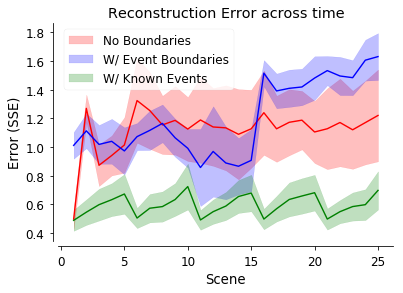

In [16]:
fig, ax = plt.subplots()

sse = np.linalg.norm(X_sample - np.tile(X, (500, 1, 1)), axis=2)
y = np.mean(sse, axis=0)
y_err = np.std(sse, axis=0)
ax.plot(range(1, 26), y, 'r')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='r', alpha=0.25, label='No Boundaries')

sse = np.linalg.norm(X_sample_uknbound - np.tile(X, (500, 1, 1)), axis=2)
y = np.mean(sse, axis=0)
y_err = np.std(sse, axis=0)
ax.plot(range(1, 26), y, 'b')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='b', alpha=0.25, label='W/ Event Boundaries')

sse = np.linalg.norm(X_sample_knownevent - np.tile(X, (500, 1, 1)), axis=2)
y = np.mean(sse, axis=0)
y_err = np.std(sse, axis=0)
ax.plot(range(1, 26), y, 'g')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='g', alpha=0.25, label='W/ Known Events')

plt.legend()
plt.ylabel('Error (SSE)')
plt.xlabel('Scene')
plt.title('Reconstruction Error across time')
sns.despine(offset=5)
plt.savefig('Divachi_reconstruction_sse.png', dpi=300, bbox_inches='tight')

Repeate the above, but this time evaluate each point without respect to time

In [17]:
def sse_no_time(sample):
    y = []
    y_err = []
    for ii in range(0, N):
        sse = np.linalg.norm(sample.reshape(-1, D) - X[ii, :].reshape(-1, D), axis=1)
        y.append(sse.mean())
        y_err.append(sse.std())
    return np.array(y), np.array(y_err)
    

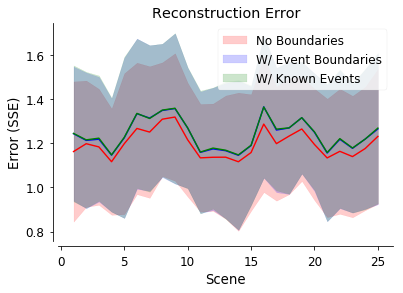

In [18]:
fig, ax = plt.subplots()

# sse = np.linalg.norm(X_sample.reshapeape(-1, D) - X, axis=2)
y, y_err = sse_no_time(X_sample)
ax.plot(range(1, 26), y, 'r')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='r', alpha=0.2, label='No Boundaries')

y, y_err = sse_no_time(X_sample_uknbound)
ax.plot(range(1, 26), y, 'b')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='b', alpha=0.2, label='W/ Event Boundaries')

y, y_err = sse_no_time(X_sample_knownevent)
ax.plot(range(1, 26), y, 'g')
ax.fill_between(range(1, 26), y+y_err, y-y_err, color='g', alpha=0.2, label='W/ Known Events')

plt.legend()
plt.ylabel('Error (SSE)')
plt.xlabel('Scene')
plt.title('Reconstruction Error')
sns.despine(offset=5)

okay great! as in the pettijohn simluations, the presense of event boundaries reduces the overall reconstruction error

# Okay! Now we can look at memory stuff

In [19]:
from sklearn.neighbors import KernelDensity

def make_joint_density(X_sample, h=0.2):
    # map the sample to sequential pairs (X_t-1, X_t) --> Y_t
    Y_sample = np.concatenate([X_sample[:, 1:, :], X_sample[:, :-1, :]], axis=2
                             ).reshape(-1, D*2)

    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Y_sample)
    return kde

def make_marginal_density(X_sample, h=0.2):
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_sample[:, 1:, :].reshape(-1, D))
    return kde

First, plot the joint distribution of items $\mathbf{x}_{i}$ and $\mathbf{x}_{i-1}$ as from t=1 (zero indexing) to N

Text(0.5,1,u'Bandwidth = 0.40')

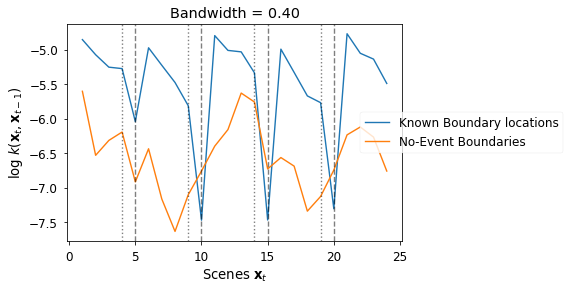

In [20]:
pre_boundary_scenes = [4, 9, 14, 19]
post_boundary_scenes = [5, 10, 15, 20]
other_scenes = [s for s in range(0, 23) if (s not in pre_boundary_scenes) & (s not in post_boundary_scenes)]



Y = np.concatenate([X[1:, :], X[:-1, :]], axis=1)


h=0.4

k_joint = make_joint_density(X_sample_uknbound, h=h)
marginals_mult = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_mult, label='Known Boundary locations')

# k_joint = make_joint_density(X_sample_knownevent, h=0.4)
# marginals_mult = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) for ii in range(0, N-1)]
# plt.plot(range(1, N), marginals_mult, label='Known Events')

k_joint = make_joint_density(X_sample, h=h)
marginals_sing = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_sing, label='No-Event Boundaries')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

ax = plt.gca()
ylb, yub = ax.get_ylim()
for b in pre_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k:', alpha=0.5)

for b in post_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k--', alpha=0.5)
    
ax.set_ylim(ylb, yub)

ax.set_ylabel(r'log $k(\mathbf{x}_{t}, \mathbf{x}_{t-1})$')
ax.set_xlabel(r'Scenes $\mathbf{x}_t$')
ax.set_title('Bandwidth = %.2f' % h)
# plt.savefig('Divachi_joint_distribution.png', dpi=300, bbox_inches='tight')

In [21]:
other_scenes

[0, 1, 2, 3, 6, 7, 8, 11, 12, 13, 16, 17, 18, 21, 22]

Next, plot the conditional distribution of items $\mathbf{x}_{i-1}|\mathbf{x}_{i}$ and  as from t=1 (zero indexing) to N

Text(0.5,1,u'Bandwidth = 0.40')

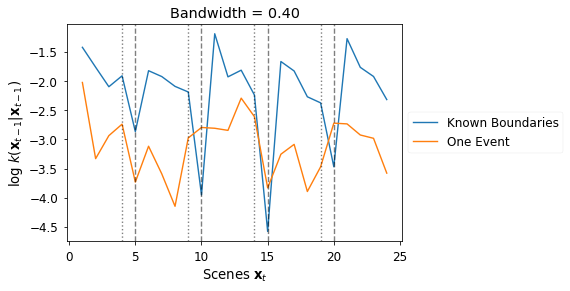

In [22]:
pre_boundary_scenes = [4, 9, 14, 19]
post_boundary_scenes = [5, 10, 15, 20]

h = 0.4

k_joint = make_joint_density(X_sample_uknbound, h=h)
k_margi = make_marginal_density(X_sample_uknbound, h=h)
marginals_mult = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) 
                  - k_margi.score_samples(X[ii-1, :].reshape(1, -1))
                  for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_mult, label='Known Boundaries')


k_joint = make_joint_density(X_sample, h=h)
k_margi = make_marginal_density(X_sample, h=h)
marginals_sing = [k_joint.score_samples(Y[ii, :].reshape(1, -1)) 
                  - k_margi.score_samples(X[ii-1, :].reshape(1, -1))
                  for ii in range(0, N-1)]
plt.plot(range(1, N), marginals_sing, label='One Event')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

ax = plt.gca()
ylb, yub = ax.get_ylim()
for b in pre_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k:', alpha=0.5)

for b in post_boundary_scenes:
    plt.plot([b, b], [ylb, yub], 'k--', alpha=0.5)
    
ax.set_ylim(ylb, yub)

ax.set_ylabel(r'log $k(\mathbf{x}_{t-1}|\mathbf{x}_{t-1})$')
ax.set_xlabel(r'Scenes $\mathbf{x}_t$')
ax.set_title('Bandwidth = %.2f' % h)

## Joint Density as a function of Bandwidth

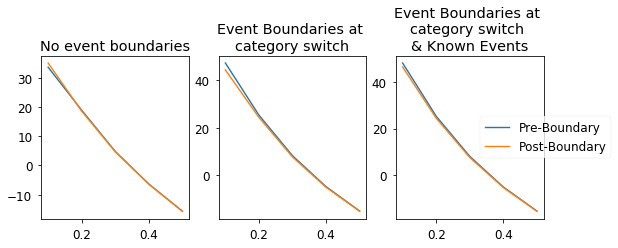

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

hs = np.arange(0.1, 0.51, 0.1)

# create the map to Y

def score_joint(sample, hs):
    
    score_pre = [None] * len(hs)
    score_pst = [None] * len(hs)
    
    for jj, h in enumerate(hs):
        # note! Y is a function from 1:N whereas everything else is a function of 0:N
        # this is b/c Y_t is a concanation of x_t & x_{t-1}, which is undefined for t = 0

        k_joint = make_joint_density(np.array(sample), h=h)

        score_pre0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) for ii in pre_boundary_scenes]
        score_pre[jj] = logsumexp(score_pre0) - np.log(len(score_pre0))

        score_pst0 = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) for ii in post_boundary_scenes]
        score_pst[jj] = logsumexp(score_pst0) - np.log(len(score_pst0))

    return score_pre, score_pst

#### one big event! ##

ax = axes[0]

score_pre, score_pst = score_joint(X_sample, hs)
    
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('No event boundaries')

#### with event boundaries! ##

ax = axes[1]

score_pre, score_pst = score_joint(X_sample_uknbound, hs)

ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('Event Boundaries at \ncategory switch')


ax = axes[2]

score_pre, score_pst = score_joint(X_sample_knownevent, hs)
    
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.set_title('Event Boundaries at \ncategory switch \n& Known Events')

plt.legend(bbox_to_anchor=(1.5, 0.5), loc='center right')

# Conditional Density as a function of Bandwidth

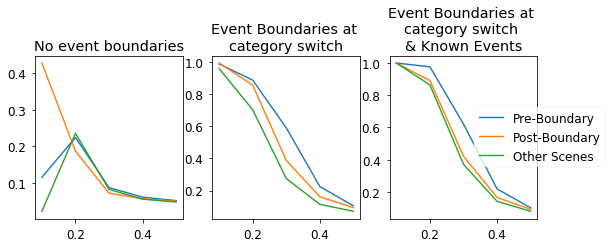

In [255]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

hs = np.arange(0.1, 0.51, 0.1)

# create the map to Y
Y = np.concatenate([X[1:, :], X[:-1, :]], axis=1)

# construct foils!
Y_foils = np.concatenate([np.concatenate([np.concatenate([X[jj+2:, :], X[1:jj+1, :]]), 
                                          np.tile(X[jj, :], (23, 1))], axis=1).reshape(23, -1, 1) 
                          for jj in range(0, 24)], axis=2)

def score_marg(sample, hs):
    prob_pre = [None] * len(hs)
    prob_pst = [None] * len(hs)
    prob_oth = [None] * len(hs)

    for jj, h in enumerate(hs):
        # note! Y is a function from 1:N whereas everything else is a function of 0:N
        # this is b/c Y_t is a concanation of x_t & x_{t-1}, which is undefined for t = 0

        k_joint = make_joint_density(np.array(sample), h=h)
        k_margi = make_marginal_density(sample, h=h)
        
        def get_prob(list_scenes):
            chance = [
                logsumexp([k_joint.score_samples(Y_foils[kk, :, ii].reshape(1, -1)) 
                           - k_margi.score_samples(X[ii, ].reshape(1, -1))
                           for kk in range(0, 23)])
                for ii in list_scenes
            ]
            chance = logsumexp(chance) - np.log(len(chance))

            score = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) 
                          - k_margi.score_samples(X[ii, ].reshape(1, -1))
                          for ii in list_scenes]
            score = logsumexp(score) - np.log(len(score))

            return np.exp(score - logsumexp([score, chance]))

        prob_pre[jj] = get_prob(pre_boundary_scenes)
        prob_pst[jj] = get_prob(post_boundary_scenes)
        prob_oth[jj] = get_prob(other_scenes)


    return prob_pre, prob_pst, prob_oth

# #### one big event! ##
ax = axes[0]
score_pre, score_pst, score_oth = score_marg(X_sample, hs)
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.plot(hs, score_oth, label='Other Scenes')
ax.set_title('No event boundaries')

#### with event boundaries! ##
ax = axes[1]
score_pre, score_pst, score_oth = score_marg(X_sample_uknbound, hs)
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.plot(hs, score_oth, label='Other Scenes')
ax.set_title('Event Boundaries at \ncategory switch')

# #### with event boundaries! ##
ax = axes[2]
score_pre, score_pst, score_oth = score_marg(X_sample_knownevent, hs)
ax.plot(hs, score_pre, label='Pre-Boundary')
ax.plot(hs, score_pst, label='Post-Boundary')
ax.plot(hs, score_oth, label='Other Scenes')
ax.set_title('Event Boundaries at \ncategory switch \n& Known Events')

plt.legend(bbox_to_anchor=(1.5, 0.5), loc='center right')

# Okay!!! Now batch the thing

In [273]:
def batch(n_samples=500, hs=None,burn_in=500):
    if hs is None:
        hs = np.arange(0.1, 0.51, 0.1)
    
    X = generate_experiment()

    event_model = train_single_event(X)
    X_sample = reconstruction_single_event(X_mem, event_model, n_samples=n_samples, burn_in=burn_in)
    
    events_token = [0] * 5 + [1] * 5 + [2] * 5 + [3] * 5 + [4] * 5

    events_dict = segment_scenes(events_token)
    
    X_sample_uknbound = reconstruction_known_boundaries(X_mem, events_dict, events_token, 
                                                        burn_in=burn_in, n_samples=n_samples)
    
    # create the map to Y
    Y = np.concatenate([X[1:, :], X[:-1, :]], axis=1)

    # construct foils!
    Y_foils = np.concatenate([np.concatenate([np.concatenate([X[jj+2:, :], X[1:jj+1, :]]), 
                                              np.tile(X[jj, :], (23, 1))], axis=1).reshape(23, -1, 1) 
                              for jj in range(0, 24)], axis=2)
    
    def score_marg(sample, hs):
        prob_pre = [None] * len(hs)
        prob_pst = [None] * len(hs)
        prob_oth = [None] * len(hs)

        for jj, h in enumerate(hs):
            # note! Y is a function from 1:N whereas everything else is a function of 0:N
            # this is b/c Y_t is a concanation of x_t & x_{t-1}, which is undefined for t = 0

            k_joint = make_joint_density(np.array(sample), h=h)
            k_margi = make_marginal_density(sample, h=h)

            def get_prob(list_scenes):
                chance = [
                    logsumexp([k_joint.score_samples(Y_foils[kk, :, ii].reshape(1, -1)) 
                               - k_margi.score_samples(X[ii, ].reshape(1, -1))
                               for kk in range(0, 23)])
                    for ii in list_scenes
                ]
                chance = logsumexp(chance) - np.log(len(chance))

                score = [k_joint.score_samples(Y[ii + 1, :].reshape(1, -1)) 
                              - k_margi.score_samples(X[ii, ].reshape(1, -1))
                              for ii in list_scenes]
                score = logsumexp(score) - np.log(len(score))

                return np.exp(score - logsumexp([score, chance]))

            prob_pre[jj] = get_prob(pre_boundary_scenes)
            prob_pst[jj] = get_prob(post_boundary_scenes)
            prob_oth[jj] = get_prob(other_scenes)


        return prob_pre, prob_pst, prob_oth

        
    marg_density = {
        'No-Boundaries': score_marg(X_sample, hs),
        'Known-Boundaries': score_marg(X_sample_uknbound, hs),
    }
    
    return marg_density

n_batches = 12
burn_in = 500
n_samples = 500
# hs = np.arange(0.15, .51, 0.025)
hs = np.arange(0.1, 0.51, 0.05)

marg_no_bound_pre = np.zeros((n_batches, len(hs)))
marg_no_bound_pst = np.zeros((n_batches, len(hs)))
marg_no_bound_oth = np.zeros((n_batches, len(hs)))
marg_known_bound_pre = np.zeros((n_batches, len(hs)))
marg_known_bound_pst = np.zeros((n_batches, len(hs)))
marg_known_bound_oth = np.zeros((n_batches, len(hs)))


for ii in tnrange(n_batches):
    marg_density = batch(n_samples, hs=hs, burn_in=burn_in)
    
    marg_no_bound_pre[ii, :] = marg_density['No-Boundaries'][0]
    marg_no_bound_pst[ii, :] = marg_density['No-Boundaries'][1]
    marg_no_bound_oth[ii, :] = marg_density['No-Boundaries'][2]
    marg_known_bound_pre[ii, :] = marg_density['Known-Boundaries'][0] 
    marg_known_bound_pst[ii, :] = marg_density['Known-Boundaries'][1]
    marg_known_bound_oth[ii, :] = marg_density['Known-Boundaries'][2]

HBox(children=(IntProgress(value=0, max=12), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

/anaconda2/envs/sem/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Gibbs', max=1000), HTML(value=u'')))

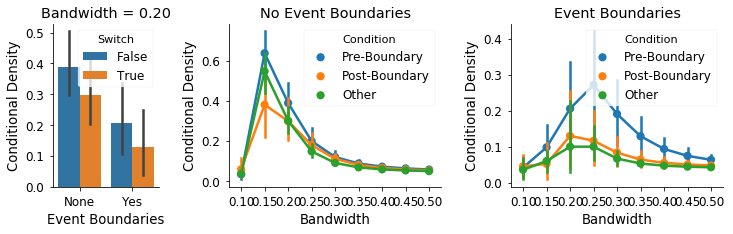

In [276]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1, 2, 2], 'wspace':0.4}, figsize=(12, 3))
import pandas as pd
h = 0.2
idx = np.arange(len(hs))[(hs - h)**2 < 0.0000001][0]
sns.set_palette('tab10')

def log_mean(x):
    return logsumexp(x, axis=0) - np.log(np.shape(x)[0])

df = pd.concat([
    pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Switch': [False] * n_batches,
        'Score': marg_no_bound_pre[:, idx],
    }), pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Switch': [True] * n_batches,
        'Score': marg_no_bound_pst[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ["Yes"] * n_batches,
        'Switch': [False] * n_batches,
        'Score': marg_known_bound_pre[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ['Yes'] * n_batches,
        'Switch': [True] * n_batches,
        'Score': marg_known_bound_pst[:, idx]
    })
    
])


sns.barplot(data=df, x='Event Boundaries', y='Score', hue='Switch', estimator=np.mean, ax=axes[0])
axes[0].set_ylabel(r'Conditional Density')
axes[0].set_title('Bandwidth = %0.2f' % h)


df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Condition': ['Pre-Boundary'] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_no_bound_pre[:, ii]
    }))
    df.append(pd.DataFrame({
        'Condition': ['Post-Boundary'] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_no_bound_pst[:, ii]
    }))
    df.append(pd.DataFrame({
        'Condition': ['Other'] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_no_bound_oth[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='Conditional Density', hue='Condition', data=df, ax = axes[1])

df = []
for ii, h in enumerate(hs):
    df.append(pd.DataFrame({
        'Condition': ['Pre-Boundary'] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_known_bound_pre[:, ii]
    }))
    df.append(pd.DataFrame({
        'Condition': ['Post-Boundary'] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_known_bound_pst[:, ii]
    }))
    df.append(pd.DataFrame({
        'Condition': ['Other'] * n_batches,
        'Bandwidth': [h] * n_batches,
        'Conditional Density': marg_known_bound_oth[:, ii]
    }))
df = pd.concat(df)

sns.pointplot(x='Bandwidth', y='Conditional Density', hue='Condition', 
                   estimator=np.mean, data=df, ax = axes[2])
axes[1].set_xticklabels(['%.2f' % h for h in hs])
axes[2].set_xticklabels(['%.2f' % h for h in hs])

axes[1].set_title('No Event Boundaries')
axes[2].set_title('Event Boundaries')

sns.despine()
# plt.savefig('Divachi_ConditionalDensity.png', dpi=300, bbox_inches='tight')

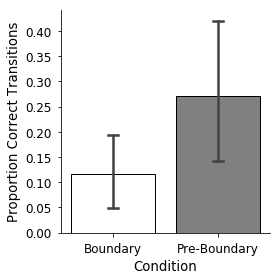

In [310]:
h = 0.25
idx = np.arange(len(hs))[(hs - h)**2 < 0.0000001][0]
sns.set_palette('tab10')

df = pd.concat([
    pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Condition': ['Boundary'] * n_batches,
        'Proportion Correct Transitions': marg_no_bound_pst[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ["None"] * n_batches,
        'Condition': ['Pre-Boundary'] * n_batches,
        'Proportion Correct Transitions': marg_no_bound_pre[:, idx],
    }), pd.DataFrame({
        'Event Boundaries': ['Yes'] * n_batches,
        'Condition': ['Boundary'] * n_batches,
        'Proportion Correct Transitions': marg_known_bound_pst[:, idx]
    }), pd.DataFrame({
        'Event Boundaries': ["Yes"] * n_batches,
        'Condition': ['Pre-Boundary'] * n_batches,
        'Proportion Correct Transitions': marg_known_bound_pre[:, idx]
    })
    
])


cc = ['w', 'grey']
sns.factorplot(data=df[df['Event Boundaries'] == 'Yes'],
               y='Proportion Correct Transitions', x='Condition', kind='bar', 
               palette = cc,
               capsize=0.1,
               linewidth=1,
               edgecolor='k',
              )
plt.savefig('Dubrow_rep.png', dpi=300)

In [289]:
help(sns.factorplot)

Help on function factorplot in module seaborn.categorical:

factorplot(x=None, y=None, hue=None, data=None, row=None, col=None, col_wrap=None, estimator=<function mean>, ci=95, n_boot=1000, units=None, order=None, hue_order=None, row_order=None, col_order=None, kind='point', size=4, aspect=1, orient=None, color=None, palette=None, legend=True, legend_out=True, sharex=True, sharey=True, margin_titles=False, facet_kws=None, **kwargs)
    Draw a categorical plot onto a FacetGrid.
    
    The default plot that is shown is a point plot, but other seaborn
    categorical plots can be chosen with the ``kind`` parameter, including
    box plots, violin plots, bar plots, or strip plots.
    
    It is important to choose how variables get mapped to the plot structure
    such that the most important comparisons are easiest to make. As a general
    rule, it is easier to compare positions that are closer together, so the
    ``hue`` variable should be used for the most important comparisons. Fo

In [264]:
marg_known_bound_pst
# marg_known_bound_pst

array([[0.02738048, 0.01376957, 0.04225836, 0.04367345],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])